## Neural network classification w/ PyTorch
https://youtu.be/V_xro1bcAuA?si=Om1cqgkY8RUoBjIf&t=30808

* Classification - predicting a label
* Regression - predicting a number

### Architecture of a classification model
* Input layer shape
* Hidden layer(s)
* Neurons per hidden layer
* Output layer shape (out_features)
* Hidden layer activation
* Output activation
* Loss function
* Optimizer

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options)

## 1. Make classification data and get it ready 

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42) # 'X' is the data (matrix) and 'y' is the label

In [2]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


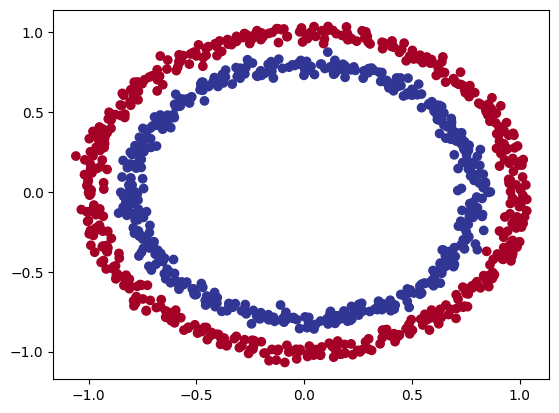

In [4]:
# Visualize, visualize, visualize...
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often referring to as a toy dataset, a dataset that is small enough to experiment on but sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train/test splits

In [7]:
import torch
torch.__version__

'2.9.0+cu126'

In [8]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
torch.manual_seed(42) # only affects PyTorch code

In [12]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # test size is 20%, train is 80%

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU - if there is one)
2. Construct a model (by sublcassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop 

In [14]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    !nvidia-smi

Sun Jan 18 21:43:56 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Now we've setup device agnostic code, let's create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass nn.Module)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [15]:
X_train.shape

torch.Size([800, 2])

In [16]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [17]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # refer to X_train shape, in features is the # of elements of each dimension, out_features is # of linear layers
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # in_features of this layer must be the same as the out_feature of previous layer

        # Another way adding linear layers
        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )
    
    # 3. Define a forward method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
        
        # return two_linear_layers(x)


# 4. Instantiate instance of model class and send to target device
model_0 = CircleModelV1().to(device)
model_0


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [19]:
# Let's replicate the model above using nn.Sequential(), similar to previous model because data is being processed to each layer in order (in sequence)
# BUT subclasses offer more custom changes
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [21]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length of predictions 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function and optimizer should you use? (for classification in this case)

* For example regression is for predicting a number - MAE or MSE would be good
* For classification you might want binary cross entropy or categorical cross entropy (cross entropy)

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options

* For the loss function, we're going to use `torch.nn.BECWithLogitsLoss()` - binary cross entropy
* What are logits???

In [22]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss - requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss - has sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [23]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

To train our model, we've going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero gradient
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model ooutputs are going to be raw **logits**.

So we can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's prediction probability to **prediction labels** by either rounding them or taking the `argmax()`

In [24]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [25]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probabiliity values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, y = 1 (class 1)
* `y_pred_probs` < 0.5, y= 0 (class 0)

In [26]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Building a training and testing loop

In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epchs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.to(device)
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities as inputs
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    # Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing 
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69331, Acc: 49.25% | Test loss: 0.69271, Test acc: 53.00%
Epoch: 10 | Loss: 0.69327, Acc: 49.75% | Test loss: 0.69279, Test acc: 54.00%
Epoch: 20 | Loss: 0.69324, Acc: 50.25% | Test loss: 0.69286, Test acc: 53.00%
Epoch: 30 | Loss: 0.69321, Acc: 49.75% | Test loss: 0.69294, Test acc: 55.00%
Epoch: 40 | Loss: 0.69319, Acc: 50.62% | Test loss: 0.69301, Test acc: 54.00%
Epoch: 50 | Loss: 0.69317, Acc: 52.25% | Test loss: 0.69307, Test acc: 51.00%
Epoch: 60 | Loss: 0.69315, Acc: 51.38% | Test loss: 0.69314, Test acc: 56.00%
Epoch: 70 | Loss: 0.69314, Acc: 51.12% | Test loss: 0.69320, Test acc: 52.00%
Epoch: 80 | Loss: 0.69313, Acc: 51.25% | Test loss: 0.69325, Test acc: 48.50%
Epoch: 90 | Loss: 0.69311, Acc: 51.00% | Test loss: 0.69331, Test acc: 50.00%
Epoch: 100 | Loss: 0.69310, Acc: 50.88% | Test loss: 0.69336, Test acc: 49.00%
Epoch: 110 | Loss: 0.69309, Acc: 50.62% | Test loss: 0.69341, Test acc: 47.50%
Epoch: 120 | Loss: 0.69309, Acc: 51.12% | Test loss: 0.69345, T

## 4. Make predictions and evaluate the model
After 100 epochs, the model is not learning and is good as guessing :(. Let's inspect his by making predictions and visualizing them!

To do so, we're going to import a function called `plot_descision_boundary()`


In [34]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

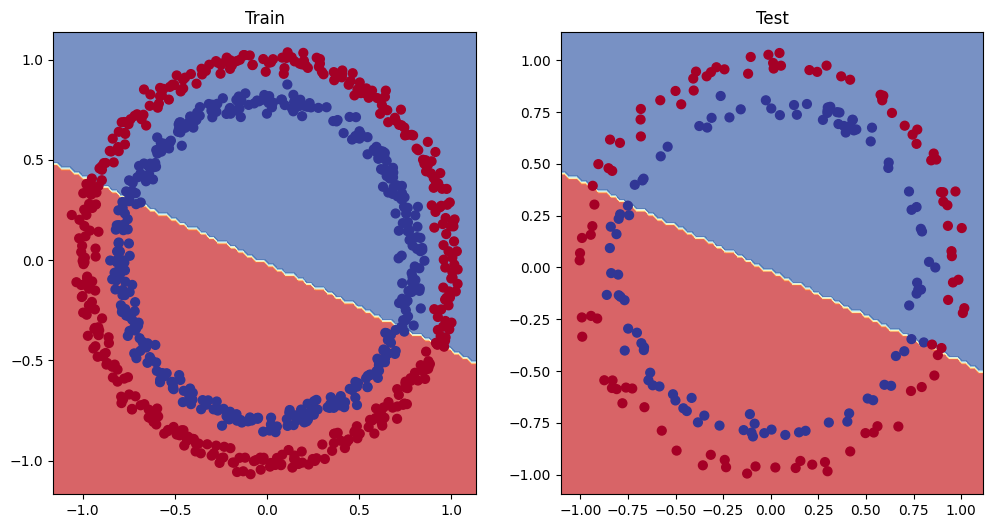

In [38]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)
After another 1000 epochs the model has actually gotten worse. There is a slight decrease in loss, which is nice, but its very little. Accuracy also decreased by about 10%.

How to improve then?
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - out_features, from 5 to 10 hidden units
* Fit for longer - increase epoch (training loops)
* Changing the activation functions - put activation functions within the model??
* Change learning rate - lr, exploding gradient problem?
* Change the loss function

https://youtu.be/V_xro1bcAuA?si=tgsss5vEzBO3Pz6r&t=39959